In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

data = pd.read_csv('data/properatti.csv')
data.head(5)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,Liniers,|Argentina|Capital Federal|Liniers|,Argentina,Capital Federal,3431333.0,"-34.6477969,-58.5164244",-34.647797,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boh_venta_ph_lin...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,...,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...


In [2]:
''' Vemos las columnas '''

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121197 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   lat-lon                     69670 non-null   object 
 9   lat                         69670 non-null   float64
 10  lon                         69670 non-null   float64
 11  price                       100810 non-null  float64
 12  currency                    100809 non-null  object 
 13  price_aprox_lo

In [3]:
data.operation.value_counts()

sell    121220
Name: operation, dtype: int64

In [4]:
data.country_name.value_counts()

Argentina    121220
Name: country_name, dtype: int64

In [5]:
'''Eliminamos las columnas que no aportan informacion, como operation es sell la quitamos'''
''' expensas también, no aporta información y es un dato que nunca se completa correctamente'''
'''country son todos de argentina no aporta nada'''

data = data.drop(['Unnamed: 0','operation','country_name','expenses','image_thumbnail', 'properati_url'], axis=1)

In [6]:
''' revisamos en que moneda se encuentran expresadas las propiedades'''
data.currency.value_counts()


USD    87587
ARS    13219
PEN        2
UYU        1
Name: currency, dtype: int64

<AxesSubplot:title={'center':'Nulos por columna'}, ylabel='Columna'>

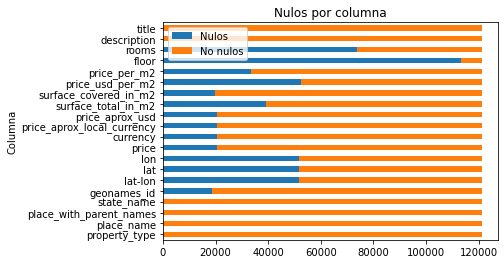

In [7]:
nulls = pd.DataFrame({'Columna':data.columns, 'Nulos':data.isnull().sum(),'No nulos':data.notnull().sum()})

# plot a Stacked Bar Chart using matplotlib
nulls.plot(
  x = 'Columna', 
  kind = 'barh', 
  stacked = True, 
  title = 'Nulos por columna', 
  mark_right = True)



In [8]:
''' completar los places names '''
data.loc[data.place_name.isnull(),'place_name'] = data.loc[data.place_name.isnull()].place_with_parent_names.str.split('|', expand=True)[3]

#Relleno manualmente un dato que está suelto
mask=(data.place_name=='coordenadas 34.255511')
data.loc[mask,'place_name'] = 'Rincón de Milberg'

'''place names nulls despues de completar'''

data.place_name.isnull().sum()


0

In [9]:
#Relleno con patron regex segun la palabra ambiente
patron = '((?P<numero>\d|mono|dos|tres|cuatro|cinco|seis)\s*(?P<ambiente>amb))'
patron_regex = re.compile(patron,flags = re.IGNORECASE)

def convertRoom(row):
    try:
        if (row['description'] and isinstance(row['description'],str)):
            resultado = patron_regex.search(row['description'])
        if ((resultado is None) and row['title'] and isinstance(row['title'],str)):
            resultado = patron_regex.search(row['title'])
        return resultado.group('numero')
    except:
        return np.nan
        
data.loc[data.rooms.isnull(),'rooms'] = data.loc[data.rooms.isnull()].apply(convertRoom,axis=1)

patron_ambientes = re.compile("(?P<Ambientes>\d+)(?P<tipo>amb|\samb)",flags = re.IGNORECASE)
patron_habitaciones = re.compile("(?P<Habitaciones>\d+)(?P<tipo>hab|\shab|dorm|\sdorm|cuartos)",flags = re.IGNORECASE)

def extractRooms(row):
    ambientes_match = None
    if ( row['description'] and isinstance(row['description'],str) ):
        ambientes_match = patron_ambientes.search(row['description'])
    if ((ambientes_match is None) and row['title'] and isinstance(row['title'],str)):
        ambientes_match = patron_ambientes.search(row['title'])
    if (ambientes_match is not None):
        return int(ambientes_match.groups()[0]) 
    else: 
        if (row['description'] and isinstance(row['description'],str)):
            ambientes_match = patron_habitaciones.search(row['description'])
        if ((ambientes_match is None) and row['title'] and isinstance(row['title'],str)):
            ambientes_match = patron_habitaciones.search(row['title'])
        if (ambientes_match is not None):
            return int(ambientes_match.groups()[0])+1
        return np.NaN
        
        
data.loc[data.rooms.isnull(),'rooms'] = data.loc[data.rooms.isnull()].apply(extractRooms,axis=1)

''' rooms despues de limpiar'''

data.rooms.isnull().sum()

25634

In [10]:
#Completamos ambas columnas de superficie

data.loc[data.surface_covered_in_m2 > data.surface_total_in_m2,'surface_total_in_m2'] = data.loc[data.surface_covered_in_m2 > data.surface_total_in_m2,'surface_covered_in_m2']

data['surface_covered_in_m2'] = data['surface_covered_in_m2'].fillna(data['surface_total_in_m2'])
data['surface_total_in_m2'] = data['surface_total_in_m2'].fillna(data['surface_covered_in_m2'])

data.loc[data.surface_total_in_m2 < 10,'surface_total_in_m2'] = np.NaN

print(data['surface_covered_in_m2'].isnull().value_counts())

print(data['surface_total_in_m2'].isnull().value_counts()) 

False    108851
True      12369
Name: surface_covered_in_m2, dtype: int64
False    108169
True      13051
Name: surface_total_in_m2, dtype: int64


In [11]:
patron_meters = re.compile("(?P<Metros>\d+)(?P<tipo>metro|\smetro|mts|\smts|m2|\sm2)",flags = re.IGNORECASE)


def extractMeters(row):
    meters_match = None
    if ( row['description'] and isinstance(row['description'],str) ):
        meters_match = patron_meters.search(row['description'])
    if ((meters_match is None) and row['title'] and isinstance(row['title'],str)):
        meters_match = patron_meters.search(row['title'])
    if (meters_match is not None):
        return meters_match.groups()[0]
    return None

data.loc[data.surface_total_in_m2.isnull(),'surface_total_in_m2'] = data.loc[data.surface_total_in_m2.isnull()].apply(extractMeters,axis=1)

data.loc[data.surface_total_in_m2.isnull() & data.surface_covered_in_m2.notnull(),'surface_total_in_m2'] = data.loc[data.surface_total_in_m2.isnull() & data.surface_covered_in_m2.notnull()].apply(lambda x: x['surface_covered_in_m2'],axis=1)

data.loc[data.surface_total_in_m2.isnull(),'surface_total_in_m2'] = data.loc[data.surface_total_in_m2.isnull()].surface_total_in_m2.fillna(value=np.nan)
data.loc[:,'surface_total_in_m2'] = data.loc[:,'surface_total_in_m2'].astype("float")

''' cuantos quedaron'''

data.surface_total_in_m2.isnull().sum()

8953

In [12]:
data.loc[data.surface_total_in_m2 < 10,'surface_total_in_m2'] = np.NaN
data.surface_total_in_m2.isnull().sum()

9714

In [13]:
''' cuantos departamentos tienen el piso en null '''
len(data.loc[(data.property_type == 'apartment') & (data.floor.isnull())].index)

64544

In [14]:
patron_floor = re.compile("(?P<piso0>planta baja|PB)|(?P<piso1>1er piso|primer piso|piso 1|1º piso|piso 1º)|(?P<piso2>2do piso|segundo piso|piso 2|2º piso|piso 2º)|(?P<piso3>3er piso|tercer piso|piso 3|3º piso|piso 3º)|(?P<piso4>4to piso|cuarto piso|piso 4|4º piso|piso 4º)|(?P<piso5>5to piso|quinto piso|piso 5|5º piso|piso 5º)|(?P<piso6>6to piso|sexto piso|piso 6|6º piso|piso 6º)|(?P<piso7>7to piso|séptimo piso|piso 7|7º piso|piso 7º)|(?P<piso8>8vo piso|octavo piso|piso 8|8º piso|piso 8º)|(?P<piso9>9no piso|noveno piso|piso 9|9º piso|piso 9º)|(?P<piso10>10mo piso|décimo piso|piso 10|10º piso|piso 10º)|(?P<piso11>11vo piso|onceavo piso|piso 11|11º piso|piso 11º)|(?P<piso12>12vo piso|doceavo piso|piso 12|12º piso|piso 12º)|(?P<piso13>13vo piso|treceavo piso|piso 13|13º piso|piso 13º)|(?P<piso14>14vo piso|cartoceavo piso|piso 14|14º piso|piso 14º)|(?P<piso15>15vo piso|quinceavo piso|piso 15|15º piso|piso 15º)",flags = re.IGNORECASE)

def extractFloor(row):
    match = None
    if (row['description'] and isinstance(row['description'],str) ):
        match = patron_floor.match(row['description'])
    if ( (match is None) and row['title'] and isinstance(row['title'],str) ):
        match = patron_floor.match(row['title'])
    if (match is not None):    
        return int(match.lastgroup.replace('piso',''))               
    return row['floor']

data.loc[(data.property_type == 'apartment') & (data.floor.isnull()),'floor'] = data.loc[(data.property_type == 'apartment') & (data.floor.isnull())].apply(lambda x: extractFloor(x),axis =1)

''' cuantos departamentos tienen el piso en null '''
len(data.loc[(data.property_type == 'apartment') & (data.floor.isnull())].index)

64238

In [15]:
data.rooms.value_counts()

3.0     20122
2.0     15909
4.0     14532
1.0      7383
3        6951
        ...  
57.0        1
43.0        1
37.0        1
29.0        1
91.0        1
Name: rooms, Length: 99, dtype: int64

In [16]:
patron_rooms_letras = re.compile("(?P<amb1>mono|uno)|(?P<amb2>dos)|(?P<amb3>tres)|(?P<amb4>cuatro)|(?P<amb5>cinco)|(?P<amb6>seis)",flags = re.IGNORECASE)

def normalizeRooms(row):
    match = None
    if ( isinstance(row['rooms'],str) ):
        match = patron_rooms_letras.match(row['rooms'])
    if (match is not None):    
        return float(match.lastgroup.replace('amb',''))      
    return float(row['rooms'])

data['rooms'] = data.apply(lambda x: normalizeRooms(x),axis=1)

In [17]:
''' columna disposicion del dpto'''

patron_disposicion = re.compile("(?P<tipo>frente|lateral|contrafrente)",flags = re.IGNORECASE)

def disposicion(row):
    disposicion_match = None
    if ( row['description'] and isinstance(row['description'],str) ): 
        disposicion_match = patron_disposicion.search(row['description'])
    if ((patron_disposicion is None) and row['title'] and isinstance(row['title'],str)):
        disposicion_match = patron_disposicion.search(row['title'])
    if (disposicion_match is not None):
        return disposicion_match.groups()[0].lower()
    return None  

data['disposicion'] =  data.apply(lambda x:disposicion(x),axis = 1)
data['disposicion'].value_counts()

frente          33854
contrafrente     6014
lateral          1954
Name: disposicion, dtype: int64

In [18]:
''' columna a estrenar '''
patron_a_estrenar = re.compile("(?P<tipo>estrenar)",flags = re.IGNORECASE)

def aestrenar(row):
    if ( row['description'] and isinstance(row['description'],str) ):
        if (patron_a_estrenar.match(row['description'])):
                return True
    if ( row['title'] and isinstance(row['title'],str) ):
        if (patron_a_estrenar.match(row['title'])):
            return True
    return False

data['aAstrenar'] = data.apply(lambda x:aestrenar(x),axis = 1);
data['aAstrenar'].value_counts()

False    121208
True         12
Name: aAstrenar, dtype: int64

In [19]:
patron = r'(\bU\$S|usd|uss|dól|dol)(\s)(?P<miles>\d+)(\.)?(?P<unidades>\d*)'

p_dls = data.loc[data.price_aprox_usd.isnull()].description.str.extract(patron, flags= re.IGNORECASE, expand = False)
p_dls['miles'] = pd.to_numeric(p_dls['miles'], errors= 'coerce')
p_dls['unidades'] = pd.to_numeric(p_dls['unidades'], errors= 'coerce')
data.loc[data.price_aprox_usd.isnull(),'price_aprox_usd'] = p_dls['miles']*1000 + p_dls['unidades']
data.price_aprox_usd.isnull().sum()


19986

In [20]:
p_dls = data.loc[data.price_aprox_usd.isnull()].title.str.extract(patron, flags= re.IGNORECASE, expand = False)
p_dls['miles'] = pd.to_numeric(p_dls['miles'], errors= 'coerce')
p_dls['unidades'] = pd.to_numeric(p_dls['unidades'], errors= 'coerce')
data.loc[data.price_aprox_usd.isnull(),'price_aprox_usd'] = p_dls['miles']*1000 + p_dls['unidades']
data.price_aprox_usd.isnull().sum()

19982

In [21]:
''' Exploramos las columnas de los precios para ver si hay datos no nulos'''

pricenull = data.loc[data['price_aprox_usd'].isna()].loc[:,['title','description','surface_covered_in_m2','price','price_aprox_local_currency','price_usd_per_m2','price_per_m2']]

pricenull.isna().sum()

title                             0
description                       0
surface_covered_in_m2          4687
price                         19982
price_aprox_local_currency    19982
price_usd_per_m2              19982
price_per_m2                  19982
dtype: int64

In [22]:
''' quitar los nulos precios '''

data = data.drop(data[data['price_aprox_usd'].isna()].index)
cant_nulls = data.isnull().sum()
print(cant_nulls)


property_type                     0
place_name                        0
place_with_parent_names           0
state_name                        0
geonames_id                   17037
lat-lon                       42394
lat                           42394
lon                           42394
price                           428
currency                        429
price_aprox_local_currency      428
price_aprox_usd                   0
surface_total_in_m2            6452
surface_covered_in_m2          7682
price_usd_per_m2              32621
price_per_m2                  13580
floor                         93995
rooms                         19654
description                       2
title                             0
disposicion                   65487
aAstrenar                         0
dtype: int64


In [23]:
data.loc[data.surface_total_in_m2.notnull() & data.price_aprox_usd.notnull() & data.price_usd_per_m2.isnull() & data.surface_total_in_m2 > 0,'price_usd_per_m2'] = data.loc[data.surface_total_in_m2.notnull() & data.price_aprox_usd.notnull() & data.price_usd_per_m2.isnull() & data.surface_total_in_m2 > 0].apply(lambda x: x['price_aprox_usd'] / x['surface_total_in_m2'],axis=1)

cant_nulls = data.isnull().sum()
print(cant_nulls)

property_type                     0
place_name                        0
place_with_parent_names           0
state_name                        0
geonames_id                   17037
lat-lon                       42394
lat                           42394
lon                           42394
price                           428
currency                        429
price_aprox_local_currency      428
price_aprox_usd                   0
surface_total_in_m2            6452
surface_covered_in_m2          7682
price_usd_per_m2               6452
price_per_m2                  13580
floor                         93995
rooms                         19654
description                       2
title                             0
disposicion                   65487
aAstrenar                         0
dtype: int64


In [24]:
''' empezamos a buscar outliers'''

pd.options.display.float_format = '{:.2f}'.format



In [25]:
data.loc[data.price_usd_per_m2 > 10000,'price_usd_per_m2'] = np.NaN

''' quitamos los que tienen 3 desvios de la media'''
data.loc[data['price_usd_per_m2']>=(data['price_usd_per_m2'].mean() + 3*data['price_usd_per_m2'].std()),'price_usd_per_m2'] = np.NaN
data.loc[data['price_aprox_usd']>=(data['price_aprox_usd'].mean() + 3*data['price_aprox_usd'].std()),'price_aprox_usd'] = np.NaN
data.loc[data['surface_total_in_m2']>=(data['surface_total_in_m2'].mean() + 3*data['surface_total_in_m2'].std()),'surface_total_in_m2'] = np.NaN



In [26]:
data.price_usd_per_m2.describe()

count   91416.00
mean     1832.90
std       936.87
min         0.35
25%      1200.00
50%      1750.00
75%      2379.10
max      5416.67
Name: price_usd_per_m2, dtype: float64

In [27]:
''' intentamos completar con los otros campos'''
data.loc[data.surface_total_in_m2.notnull() & data.price_aprox_usd.notnull() & data.price_usd_per_m2.isnull() & data.surface_total_in_m2 > 0,'price_usd_per_m2'] = data.loc[data.surface_total_in_m2.notnull() & data.price_aprox_usd.notnull() & data.price_usd_per_m2.isnull() & data.surface_total_in_m2 > 0].apply(lambda x: x['price_aprox_usd'] / x['surface_total_in_m2'],axis=1)
data.loc[data.surface_total_in_m2.notnull() & data.price_aprox_usd.isnull() & data.price_usd_per_m2.notnull() & data.surface_total_in_m2 > 0,'price_aprox_usd'] = data.loc[data.surface_total_in_m2.notnull() & data.price_aprox_usd.isnull() & data.price_usd_per_m2.notnull() & data.surface_total_in_m2 > 0].apply(lambda x: x['price_usd_per_m2'] * x['surface_total_in_m2'],axis=1)
data.loc[data.surface_total_in_m2.isnull() & data.price_aprox_usd.notnull() & data.price_usd_per_m2.notnull() & data.price_usd_per_m2 > 0,'surface_total_in_m2'] = data.loc[data.surface_total_in_m2.isnull() & data.price_aprox_usd.notnull() & data.price_usd_per_m2.notnull() & data.price_usd_per_m2 > 0].apply(lambda x: x['price_aprox_usd'] / x['price_usd_per_m2'],axis=1)




In [28]:
''' quitamos los registros sin info relevante'''

columnsUtils = ['surface_total_in_m2','price_aprox_usd', 'price_usd_per_m2']

data = data.dropna(axis =0 , how = 'any', subset = columnsUtils)


In [29]:
data = data.drop(data.loc[data.price_usd_per_m2 > 10000].index)


<AxesSubplot:title={'center':'Nulos por columna'}, ylabel='Columna'>

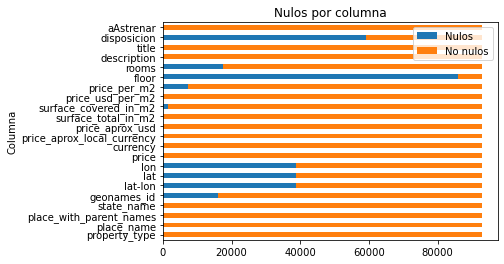

In [30]:
nulls2 = pd.DataFrame({'Columna':data.columns, 'Nulos':data.isnull().sum(),'No nulos':data.notnull().sum()})

# plot a Stacked Bar Chart using matplotlib
nulls2.plot(
  x = 'Columna', 
  kind = 'barh', 
  stacked = True, 
  title = 'Nulos por columna', 
  mark_right = True)

In [31]:
''' nos vamos a quedar con capital federal'''

data = data.loc[(data.state_name == 'Capital Federal')]
data.place_name.unique()


array(['Mataderos', 'Belgrano', 'Palermo Soho', 'Palermo', 'Flores',
       'Boedo', 'Las Cañitas', 'Puerto Madero', 'Balvanera', 'Caballito',
       'Nuñez', 'Almagro', 'Capital Federal', 'Colegiales', 'Floresta',
       'Barrio Norte', 'Barracas', 'Recoleta', 'Congreso', 'Villa Crespo',
       'Chacarita', 'Constitución', 'Villa Urquiza', 'Palermo Hollywood',
       'Saavedra', 'Parque Chas', 'Paternal', 'Agronomía',
       'Villa Pueyrredón', 'Coghlan', 'Parque Centenario', 'San Telmo',
       'Monserrat', 'Villa Devoto', 'Boca', 'Parque Avellaneda',
       'San Cristobal', 'Abasto', 'Versalles', 'Villa del Parque',
       'Monte Castro', 'Retiro', 'Parque Patricios', 'San Nicolás',
       'Villa Santa Rita', 'Palermo Chico', 'Liniers',
       'Centro / Microcentro', 'Once', 'Tribunales', 'Parque Chacabuco',
       'Velez Sarsfield', 'Catalinas', 'Pompeya', 'Palermo Viejo',
       'Villa Lugano', 'Villa Luro', 'Villa General Mitre',
       'Villa Ortuzar', 'Villa Soldati', 'Villa Re

In [32]:
#1. Copio los barrios y los Palermos los convierto a Palermo
data['place_name'] = data.place_name.apply(lambda x: "Palermo" if "Palermo" in x else x)

In [33]:
data.place_name.unique()

array(['Mataderos', 'Belgrano', 'Palermo', 'Flores', 'Boedo',
       'Las Cañitas', 'Puerto Madero', 'Balvanera', 'Caballito', 'Nuñez',
       'Almagro', 'Capital Federal', 'Colegiales', 'Floresta',
       'Barrio Norte', 'Barracas', 'Recoleta', 'Congreso', 'Villa Crespo',
       'Chacarita', 'Constitución', 'Villa Urquiza', 'Saavedra',
       'Parque Chas', 'Paternal', 'Agronomía', 'Villa Pueyrredón',
       'Coghlan', 'Parque Centenario', 'San Telmo', 'Monserrat',
       'Villa Devoto', 'Boca', 'Parque Avellaneda', 'San Cristobal',
       'Abasto', 'Versalles', 'Villa del Parque', 'Monte Castro',
       'Retiro', 'Parque Patricios', 'San Nicolás', 'Villa Santa Rita',
       'Liniers', 'Centro / Microcentro', 'Once', 'Tribunales',
       'Parque Chacabuco', 'Velez Sarsfield', 'Catalinas', 'Pompeya',
       'Villa Lugano', 'Villa Luro', 'Villa General Mitre',
       'Villa Ortuzar', 'Villa Soldati', 'Villa Real', 'Villa Riachuelo'],
      dtype=object)

In [34]:
'''propiedades de capital'''
len(data.index)

27642

In [35]:
data.rooms.describe()

count   24236.00
mean        2.72
std         2.03
min         0.00
25%         2.00
50%         3.00
75%         4.00
max       126.00
Name: rooms, dtype: float64

In [36]:
data.loc[data.rooms > 10,"property_type"] = "special"

In [37]:
data.loc[data.rooms > 10]

,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,currency,...,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,description,title,disposicion,aAstrenar
876,special,San Nicolás,|Argentina|Capital Federal|San Nicolás|,Capital Federal,6693229.00,"-34.605661,-58.388343",-34.61,-58.39,250000.00,USD,...,382.00,382.00,654.45,654.45,1.00,17.00,Corredor Responsable: Mario Gabriel Gerez - CU...,Venta Hotel Familiar en 2 pisos,frente,False
877,special,Monserrat,|Argentina|Capital Federal|Monserrat|,Capital Federal,3430570.00,"-34.609988,-58.374932",-34.61,-58.37,300000.00,USD,...,472.00,472.00,635.59,635.59,1.00,22.00,Corredor Responsable: Mario Gabriel Gerez - CU...,Venta Hotel Familiar Calle Peru al 100,None,False
9426,special,Capital Federal,|Argentina|Capital Federal|,Capital Federal,3433955.00,NaN,nan,nan,365000.00,USD,...,136.00,110.00,2683.82,3318.18,1.00,33.00,VENTA CON RENTA!Exclusivo Barrio Cerrado en La...,"Departamento 136m² con Plantas, Argentina, Cap...",None,False
10592,special,Villa Pueyrredón,|Argentina|Capital Federal|Villa Pueyrredón|,Capital Federal,3429703.00,"-34.5835159,-58.497411",-34.58,-58.50,700000.00,USD,...,500.00,400.00,1400.00,1750.00,nan,12.00,Se trata de dos propiedades en una: --> --> en...,"Depto 5amb + Casa 7amb, Cochera Para 6 autos",None,False
11721,special,Constitución,|Argentina|Capital Federal|Constitución|,Capital Federal,3435257.00,"-34.6196440159,-58.3783563841",-34.62,-58.38,249000.00,USD,...,200.00,200.00,1245.00,1245.00,nan,12.00,VENTA DE PISO TIPO PH (1º PISO) U$S 249.000 “C...,VENTA PISO TIPO PH - de 200 m2 - Balcón al Frte -,None,False
11722,special,San Telmo,|Argentina|Capital Federal|San Telmo|,Capital Federal,3428113.00,"-34.6196545664,-58.3783370836",-34.62,-58.38,249000.00,USD,...,200.00,200.00,1245.00,1245.00,nan,12.00,VENTA DE PISO TIPO PH (1º PISO) U$S 249.000 “C...,PISO DE 200 M2 - Carlos Calvo al 800 - San Tel...,None,False
13044,special,Recoleta,|Argentina|Capital Federal|Recoleta|,Capital Federal,3429595.00,"-34.5921249227,-58.3790816634",-34.59,-58.38,1200000.00,USD,...,366.00,363.00,3278.69,3305.79,nan,12.00,- Excelente piso de 375m en edificio Francés d...,Arroyo y Esmeralda: oficina / vivienda Frances...,frente,False
13065,special,Recoleta,|Argentina|Capital Federal|Recoleta|,Capital Federal,3429595.00,"-34.5924495,-58.3926388",-34.59,-58.39,1280000.00,USD,...,535.00,509.00,2392.52,2514.73,nan,12.00,"Espectacular recepción de sala, doble living y...",Av. Callao - Juncal: Piso de categoría. Cocher...,None,False
13158,special,Belgrano,|Argentina|Capital Federal|Belgrano|,Capital Federal,3436077.00,"-34.570631,-58.462415",-34.57,-58.46,2500000.00,USD,...,1015.00,1015.00,2463.05,2463.05,nan,12.00,Corredor Responsable: Daniel Acosta - CUCICBA ...,Imponente residencia 720 mts2 de terreno y 3 p...,frente,False
13236,special,Almagro,|Argentina|Capital Federal|Almagro|,Capital Federal,3436397.00,"-34.610983,-58.415697",-34.61,-58.42,240000.00,USD,...,180.00,180.00,1333.33,1333.33,nan,11.00,Corredor Responsable: Marcelo Trujillo - CUCIC...,Venta PH TODO DESTINO en Almagro,frente,False


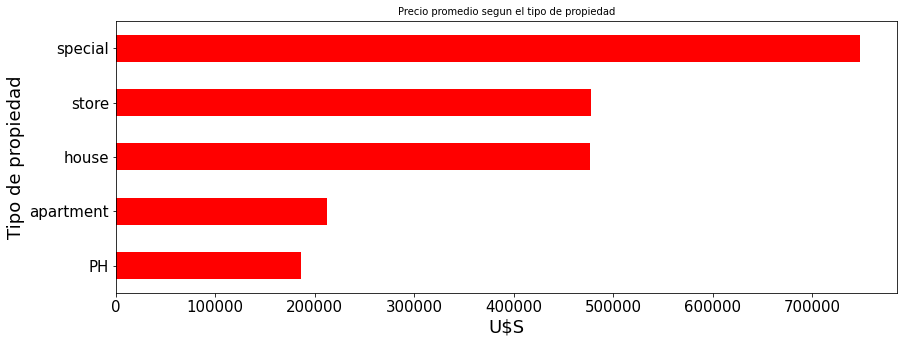

In [38]:
df_tipo_prop = data.groupby('property_type').mean()['price_aprox_usd'].sort_values(ascending=False)[0:5]
graf = df_tipo_prop.sort_values().plot.barh(figsize=(14,5),fontsize=15, color='r')
graf.set_title("Precio promedio segun el tipo de propiedad", fontsize=10)
graf.set_ylabel("Tipo de propiedad", fontsize=18)
graf.set_xlabel("U$S", fontsize=18)
plt.show()

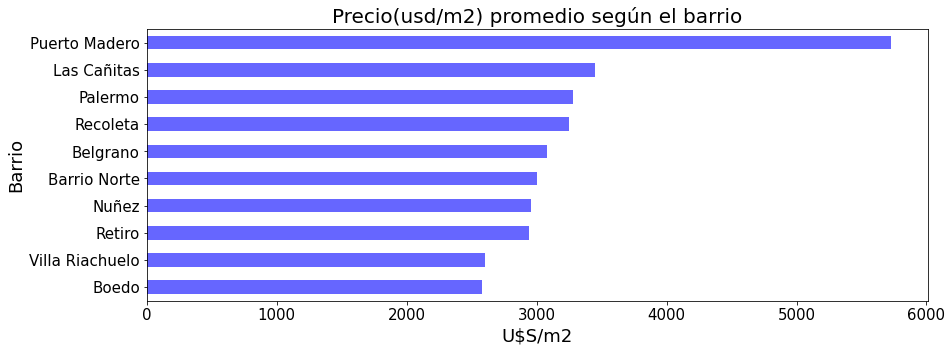

In [39]:
dfzone = data.groupby('place_name').mean()['price_usd_per_m2'].sort_values(ascending=False)[0:10]
g = dfzone.sort_values().plot.barh(figsize=(14,5),color='b',fontsize=15, alpha=0.6);
g.set_title("Precio(usd/m2) promedio según el barrio", fontsize=20)
g.set_ylabel("Barrio", fontsize=18)
g.set_xlabel("U$S/m2", fontsize=18)
plt.show()